# Quantum Quipu - Qiskit Fall Fest Latino

**Descripción:** Este notebook presenta los resultados obtenidos al implementar el algoritmo de Data Reuploading para la clasificación de datos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Analisis de Datos

In [2]:
# Load the data
test_data = pd.read_csv('challenge_test.csv', index_col=0)
train_data = pd.read_csv('challenge_train.csv', index_col=0)

Los datos tienen la siguiente estructura:

- 2 clases   (Target)
- 4 features (F1, F2, F3, F4)

In [3]:
train_data.head()

,F1,F2,F3,F4,Target
0,-0.291592,1.854606,-0.226004,1.694754,1
1,0.327501,1.584748,-1.300541,0.471729,1
2,0.227985,1.512023,-0.646984,-0.743707,1
3,-0.453525,1.819041,-0.870957,-1.452390,1
4,-1.480420,1.278968,-1.193171,-0.000952,1


Los datos se normalizaron para estar dentro del rango $[-\pi,\pi]$. Esta normalización se llevó a cabo para asegurar que los datos sean compatibles con el algoritmo de Data Reuploading.

La preparación de los datos se efectuó utilizando el código contenido en el archivo prepare_data.py.

In [4]:
from prepare_data import Data

In [5]:
data_scaled = Data(train_data, test_data)
data_scaled.prepare_data()

X_test = data_scaled.X_test_scaled
y_test = data_scaled.y_test

X_train = data_scaled.X_train_scaled
y_train = data_scaled.y

Antes de iniciar el proceso de clasificación, se analizaron los datos para identificar posibles correlaciones entre las características (features) y el objetivo (target).

In [6]:
import seaborn as sns

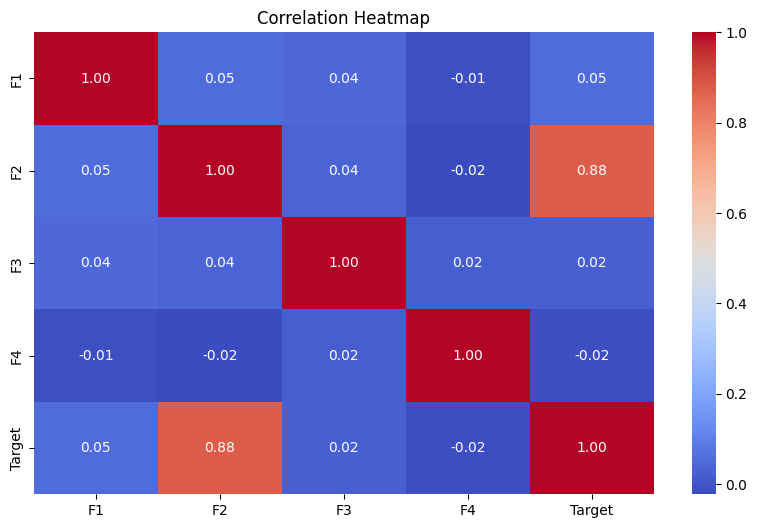

In [7]:
# Visualizing correlations between numerical features using a heatmap
plt.figure(figsize=(10, 6))
correlation = train_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Del heatmap, se puede observar una correlación significativa entre la Feature **F2** y el target. Respecto a las demás features, no se detecta una correlación relevante.

A continuación, se presenta un gráfico pairplot de los datos. En él, se nota una clara separación entre las clases 0 y 1 en la feature F2, mientras que en las demás features no se aprecia una separación nítida entre las clases. De esto se infiere que la feature F2 es crucial para la clasificación de los datos y será la única feature utilizada en el algoritmo de Data Reuploading.

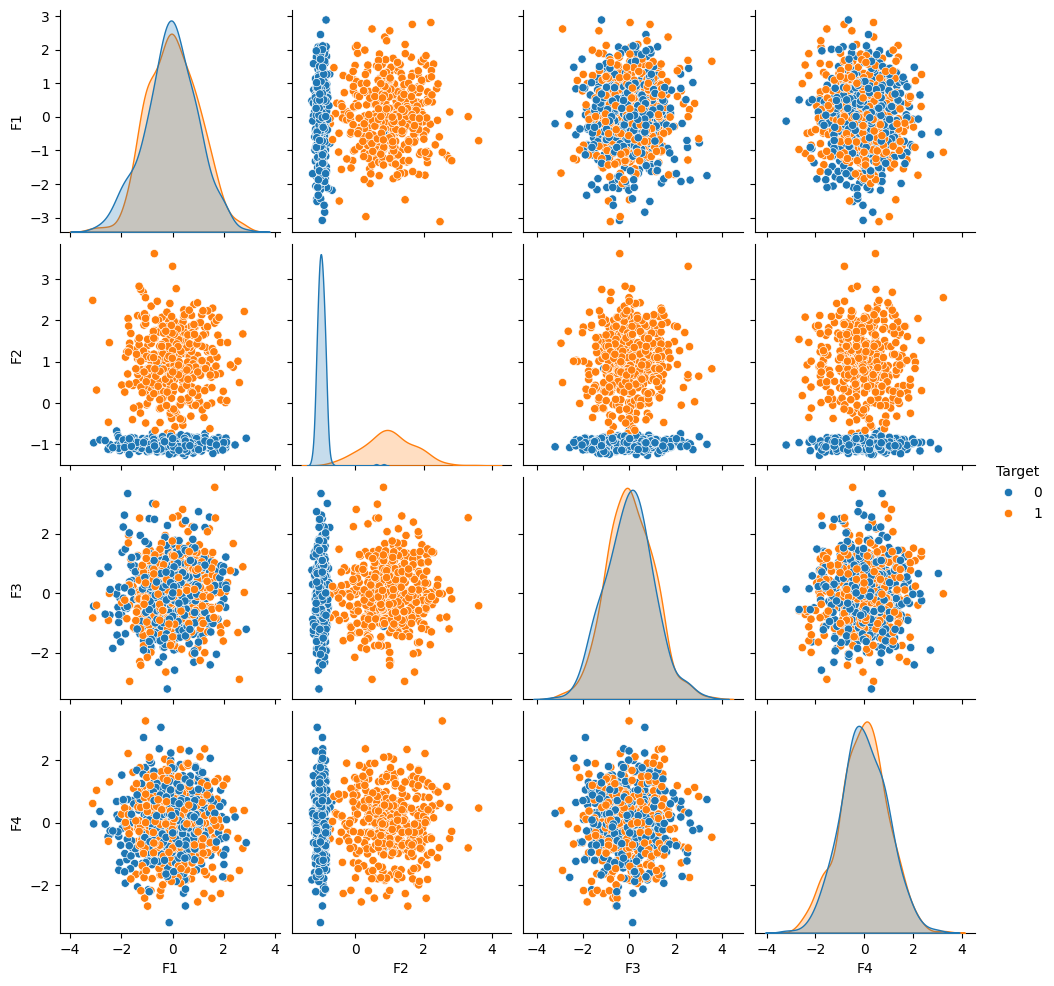

In [8]:
# Pairplot for visualizing relationships between different features
sns.pairplot(train_data, hue='Target')
plt.show()

# Clasificación

Para la clasificación de los datos, se empleó el algoritmo de Data Reuploading. Este método implica la repetición de capas $L(\theta_i, x)$ donde $\theta_i$ es un vector de parámetros y $x$ es el vector de características. Cada capa se compone de la siguiente manera:

$$L(\theta_i,x) = S(x) W(\theta_i)$$

Donde $S(x)$ es el bloque de codificación y $W(\theta_i)$ es el bloque de parámetros entrenables. Al final de varias capas, se coloca un bloque adicional de entrenamiento para asegurar que siempre se alternen entre un bloque de codificación y uno de entrenamiento.

Es importante señalar que en el caso de que exista más de un qubit, el bloque de codificación puede repetirse o no en cada qubit. Además, el bloque entrenable tiene capas de entrelazamiento entre los qubits.

La elección de este método de codificación y entrenamiento se fundamenta en los recientes resultados de (Maria Schuld et al., 2021) [^1] y (Adrián Pérez-Salinas et al., 2020) [^2]. En [^1] se muestra que un único qubit puede utilizarse como un clasificador universal con el número adecuado de capas y el observable adecuado. Por otro lado, [^2] revela que el Data Reuploading es un aproximador universal de funciones continuas, siempre y cuando estas puedan aproximarse en series de Fourier. El número de frecuencias accesibles por el circuito está limitado por el número de capas de codificación, y las amplitudes de las frecuencias están definidas por todo el circuito.

Basándonos en esto y considerando la simplicidad del problema, es factible concluir que el problema puede resolverse usando únicamente un qubit y una capa, resultados que se mostrarán a continuación.

[^1]: https://arxiv.org/abs/1907.02085
[^2]: https://arxiv.org/abs/2008.08605

### Entrenamiento

Se llevaron a cabo los entrenamientos de varios circuitos utilizando PyTorch con el optimizador Adam. Se empleó un learning rate variable de 0.2 y un batch size de 100. El entrenamiento se extendió a lo largo de 100 epochs. Se redujo el learning rate en un factor de 0.5 cada 10 epochs si el loss no mejoraba, deteniendo el entrenamiento si el loss no mejoraba después de 3 reducciones del learning rate.

#### Loss

Para establecer una función de costo, se definió un observable $O$ que se puede medir en el circuito. En este caso, se utilizó el proyector del estado $\ket{0}$ y $\ket{1}$ para las etiquetas 0 y 1, respectivamente. De esta manera, se buscó optimizar la fidelidad del estado resultante del circuito variacional con el estado objetivo. La función de pérdida se definió como la media de la diferencia al cuadrado entre la fidelidad del estado objetivo y el valor máximo posible de 1.

$$Loss = \frac{1}{N} \sum_{i=1}^N (1 - \braket{\psi_i|\psi(x_i)})^2$$

Donde $\ket{\psi(x_i)}$ representa el estado resultante del circuito variacional y $\ket{\psi_i}$ es el estado objetivo.

Todo el código utilizado para el entrenamiento se encuentra en el archivo `data_reuploading_pennylane_pytorch.py`.


# Resultados

Se entrenaron 5 circuitos para comparar la calidad de la solución, la cantidad de recursos utilizados y cómo estos afectan a la solución. Los circuitos se diferencian en la cantidad de capas de codificación y la cantidad de qubits utilizados. Los resultados se almacenaron en la carpeta `best_params_pytorch/`.

### Utils

In [9]:
from data_reuploading_pennylane_pytorch import DataReuploadingClassifier
import pennylane as qml
import pickle

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [10]:
def load_classifier(nl, nq, lr, ep, acc, auc):
    Path = 'best_params_pytorch/'
    filename = f'nl_{nl}_nq_{nq}_lr_{lr}_ep_{ep}_acc_{acc:.3f}_auc_{auc:.3f}'

    total_path = Path + filename + '/'

    # Load the best parameters
    with open(total_path + filename + '.npy', 'rb') as f:
        best_params = np.load(f)

    # Load the history
    with open(total_path + filename + '.pkl', 'rb') as f:
        history = pickle.load(f)
    
    return best_params, history

In [11]:
def plot_history(classifier):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].plot(classifier.history['loss'], label='Training Loss', color='blue')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].plot(classifier.history['acc'], label='Training Accuracy', color='red')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    ax[0].legend()
    ax[1].legend()

    return fig, ax

In [12]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

    return fig, ax

In [13]:
def density_matrix(state):
    return np.outer(state, np.conj(state))

def prediction_graph(circuit, X, Y):
    state_0 = np.array([1, 0])
    state_1 = np.array([0, 1])

    density_matrix_states = [density_matrix(state_0), density_matrix(state_1)]

    x = np.linspace(-np.pi, np.pi, 100)
    expval_Z = [circuit.circuit(x_i, circuit.best_params) for x_i in x]
    p_0 = [circuit.circuit(x_i, circuit.best_params, density_matrix_states[0]) for x_i in x]
    p_1 = [circuit.circuit(x_i, circuit.best_params, density_matrix_states[1]) for x_i in x]

    y_pred = circuit._predict(X)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x, expval_Z, label=r'Expectation Value $\langle Z\rangle$')
    ax.plot(x, p_0, label=r'Probability $|0\rangle$')
    ax.plot(x, p_1, label=r'Probability $|1\rangle$')
    ax.scatter(X, Y, label='Data', color='black', marker='x', alpha=0.5)
    ax.scatter(X, y_pred, label='Predictions', color='red', marker='o', alpha=0.5)

    ax.set_xlabel('Input $x$')
    ax.set_title('Prediction Graph')

    ax.legend()

    return fig, ax


Los circuitos se muestran a seguir:

## Circuito 1
- Número de Qubits: 1
- Número de Layers: 1
- Número de Parámetros: 6 (3 por cada rotación)

**Accuracies:**

- Training Accuracy: 0.9875
- Test Accuracy: 0.995

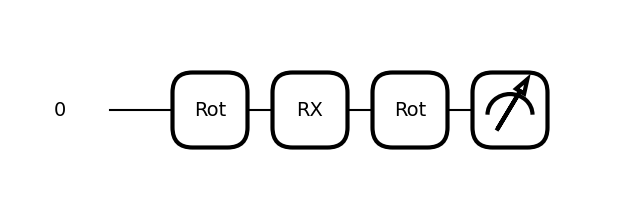

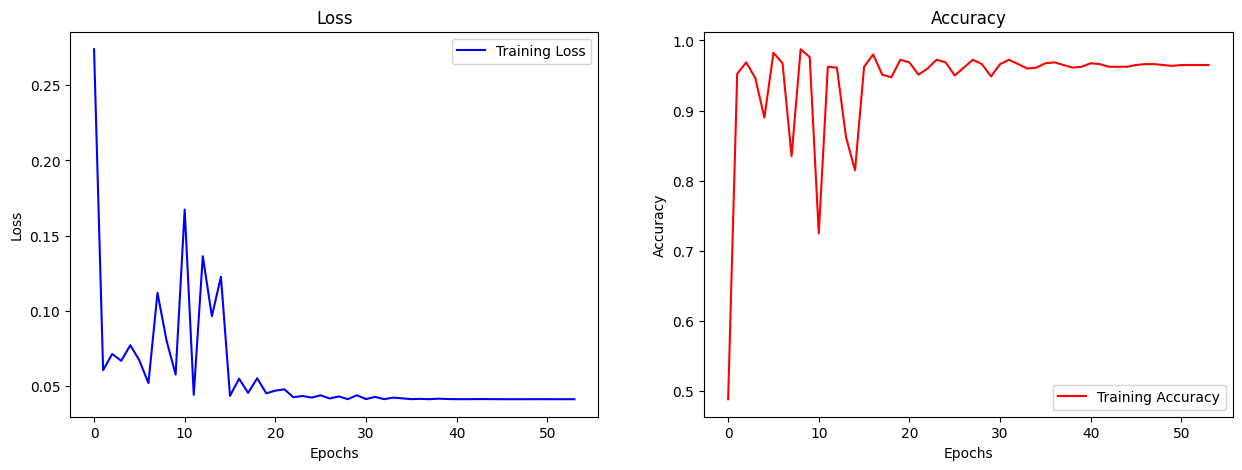

In [14]:
n_qubits = 1
n_layers = 1
lr = 0.2
ep = 100
acc = 0.995
auc = 0.995

best_params_c1, history_c1 = load_classifier(n_layers, n_qubits, lr, ep, acc, auc)

circuit_1 = DataReuploadingClassifier(n_qubits, n_layers)
circuit_1.best_params = best_params_c1
circuit_1.history = history_c1

qml.draw_mpl(circuit_1.circuit)(X_train['F2'][0], circuit_1.best_params)
fig, ax = plot_history(circuit_1)

Es posible observar que el entrenamiento se estabiliza aproximadamente después de las 30 epochs. A continuación se muestran los resultados de la precisión (accuracy) para los datos de entrenamiento y test.

In [15]:
print('Accuracy on the training set: ', accuracy_score(y_train, circuit_1._predict(X_train['F2'])))
print('Accuracy on the test set: ', accuracy_score(y_test, circuit_1._predict(X_test['F2'])))

Accuracy on the training set:  0.9875
Accuracy on the test set:  0.995


El accuracy en el conjunto de test es del 0.995, lo que representa el 99.5% de los datos clasificados correctamente. En el dataset de test, que consta de 200 datos, esto significa que solo 1 dato fue clasificado incorrectamente. Esta discrepancia se puede apreciar fácilmente en el gráfico de la matriz de confusión.

Por otro lado, el accuracy en el conjunto de entrenamiento es del 0.9875, lo que representa el 98.75% de los datos clasificados correctamente. En el dataset de entrenamiento, que comprende 800 datos, esto significa que 10 datos fueron clasificados incorrectamente. Esto también se refleja claramente en el gráfico de la matriz de confusión.

Training Data


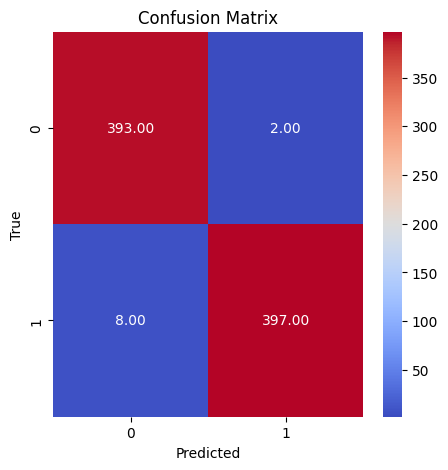

Test Data


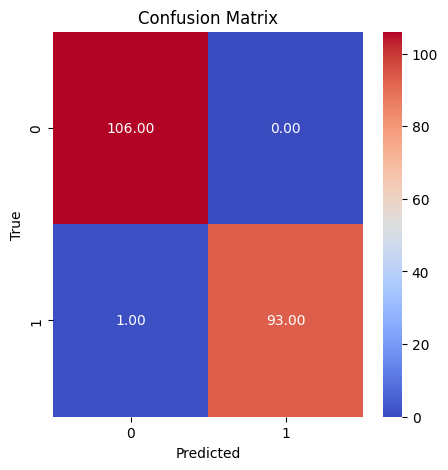

In [16]:
# Confusion matrix
print('Training Data')
fig, ax = plot_confusion_matrix(y_train, circuit_1._predict(X_train['F2']))
plt.show()

print('Test Data')
fig, ax = plot_confusion_matrix(y_test, circuit_1._predict(X_test['F2']))
plt.show()

Además, para visualizar adecuadamente la relación entre los datos y la clasificación obtenida por el circuito, se presenta un gráfico que muestra los datos y su clasificación. En este gráfico, se puede observar que se confirma que un único qubit es suficiente para clasificar los datos, respaldando la noción de que un qubit puede actuar como un clasificador universal utilizando data reuploading. Además, se verifica que al emplear solo una capa de codificación, las funciones que se pueden aproximar tienen una única frecuencia, y esta función senoidal es suficiente para clasificar los datos.

Training Data


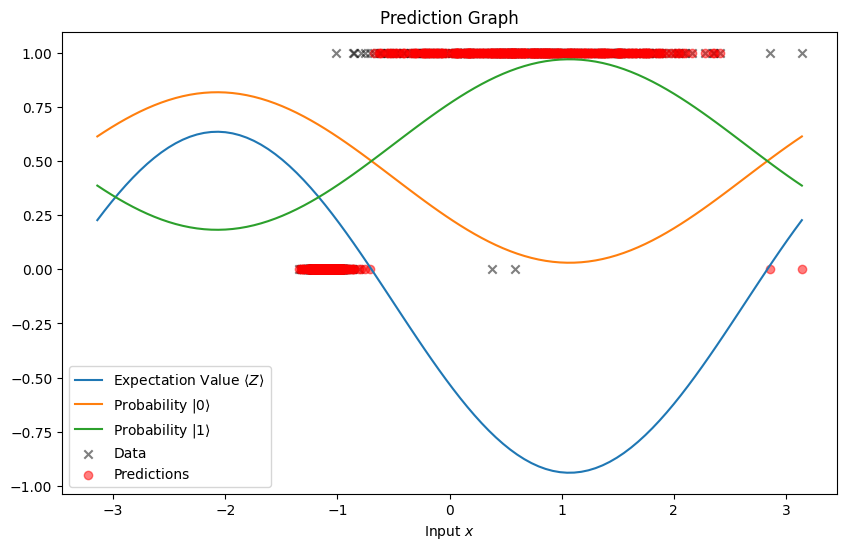

Test Data


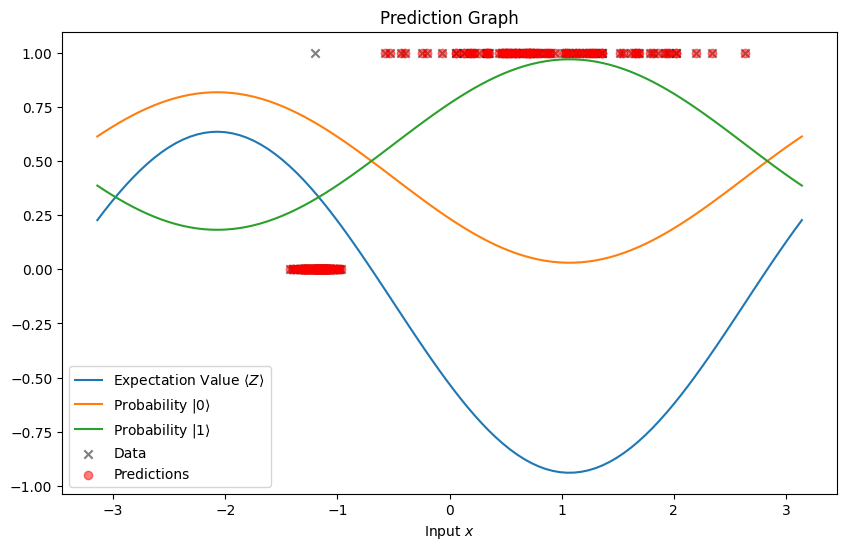

In [17]:
print('Training Data')
fig, ax = prediction_graph(circuit_1, X_train['F2'], y_train)
plt.show()

print('Test Data')
fig, ax = prediction_graph(circuit_1, X_test['F2'], y_test)
plt.show()

## Circuito 2

- Número de Qubits: 1
- Número de Layers: 2
- Número de Parámetros: 9 (3 por cada rotación)

**Accuracies:**

- Training Accuracy: 0.9925
- Test Accuracy: 0.995

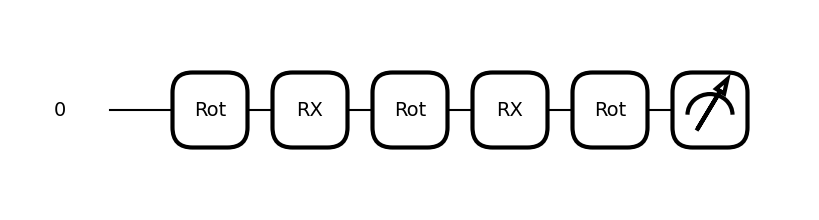

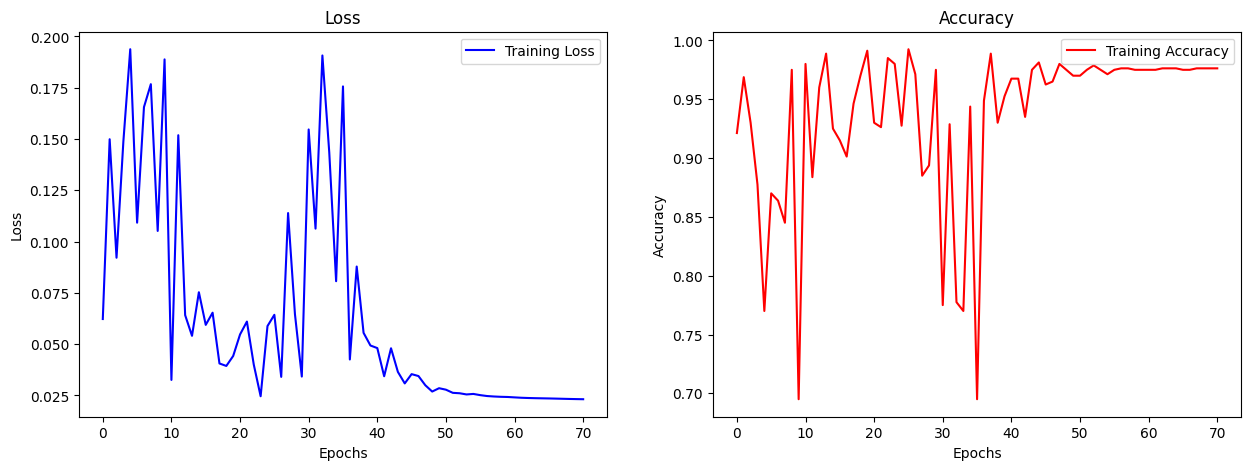

In [18]:
n_qubits = 1
n_layers = 2
lr = 0.2
ep = 100
acc = 0.995
auc = 0.995 

best_params_c2, history_c2 = load_classifier(n_layers, n_qubits, lr, ep, acc, auc)

circuit_2 = DataReuploadingClassifier(n_qubits, n_layers)
circuit_2.best_params = best_params_c2
circuit_2.history = history_c2

qml.draw_mpl(circuit_2.circuit)(X_train['F2'][0], circuit_2.best_params)
fig, ax = plot_history(circuit_2)

In [19]:
print('Accuracy on the training set: ', accuracy_score(y_train, circuit_2._predict(X_train['F2'])))
print('Accuracy on the test set: ', accuracy_score(y_test, circuit_2._predict(X_test['F2'])))

Accuracy on the training set:  0.9925
Accuracy on the test set:  0.995


Para este caso específico, se puede observar que el entrenamiento se estabiliza aproximadamente después de las 50 epochs. Esto sugiere que se necesitan más epochs a medida que se aumenta la cantidad de capas para que el circuito converja. Sin embargo, es posible alcanzar una máxima precisión (accuracy) de 0.995 en el conjunto de test, aunque se logra una precisión mayor en el conjunto de entrenamiento, llegando a 0.9925, lo que representa el 99.25% de los datos clasificados correctamente en el dataset de entrenamiento que consta de 800 datos.

Training Data


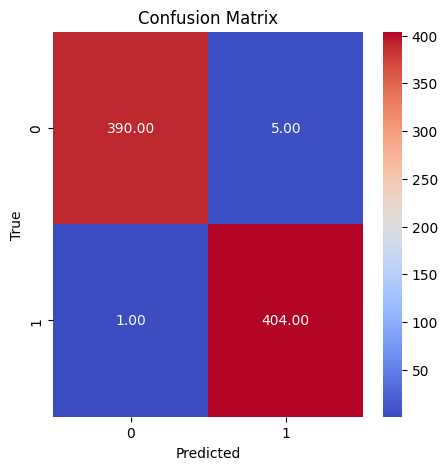

Test Data


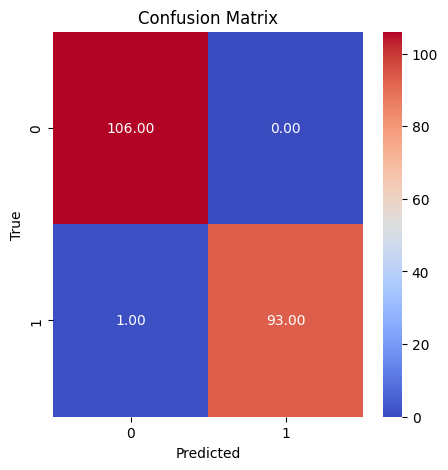

In [20]:
# Confusion matrix
print('Training Data')
fig, ax = plot_confusion_matrix(y_train, circuit_2._predict(X_train['F2']))
plt.show()

print('Test Data')
fig, ax = plot_confusion_matrix(y_test, circuit_2._predict(X_test['F2']))
plt.show()

Training Data


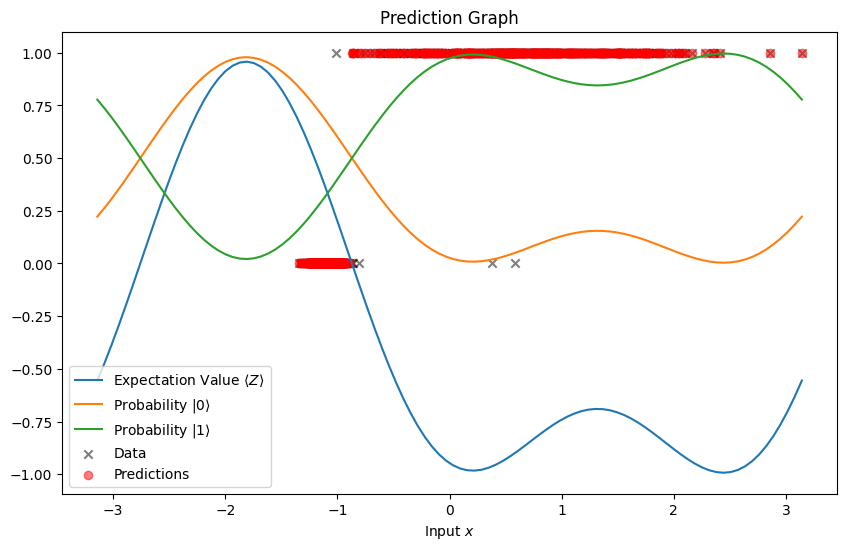

Test Data


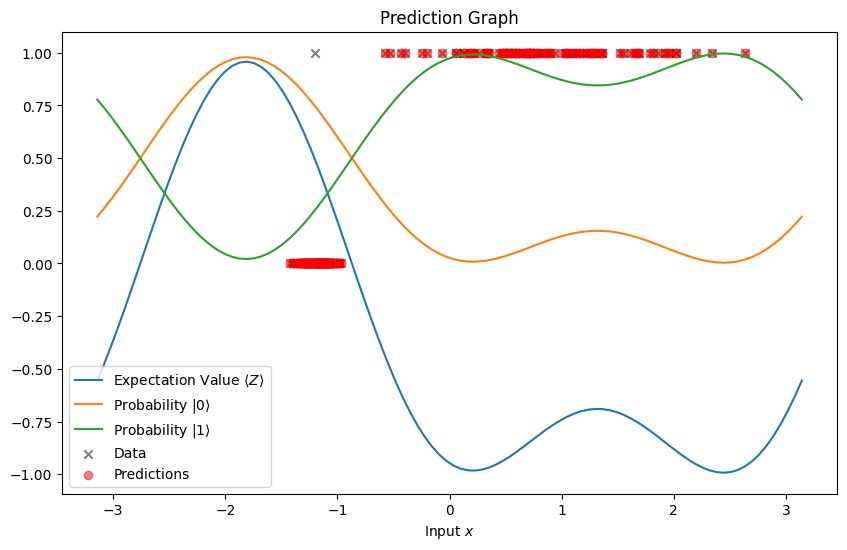

In [21]:
print('Training Data')
fig, ax = prediction_graph(circuit_2, X_train['F2'], y_train)
plt.show()

print('Test Data')
fig, ax = prediction_graph(circuit_2, X_test['F2'], y_test)
plt.show()

Los gráficos anteriores muestran que el circuito clasifica los datos de manera precisa, y la mayor precisión en los datos de entrenamiento se debe al hecho de que con una capa adicional de codificación se pueden obtener más frecuencias, es decir, 2 frecuencias en lugar de 1. Esto conlleva a una mejor aproximación de la función que clasifica de manera más efectiva los datos

## Circuito 3

- Número de Qubits: 1
- Número de Layers: 3
- Número de Parámetros: 12 (3 por cada rotación)

**Accuracies:**

- Training Accuracy: 0.9925
- Test Accuracy: 0.995

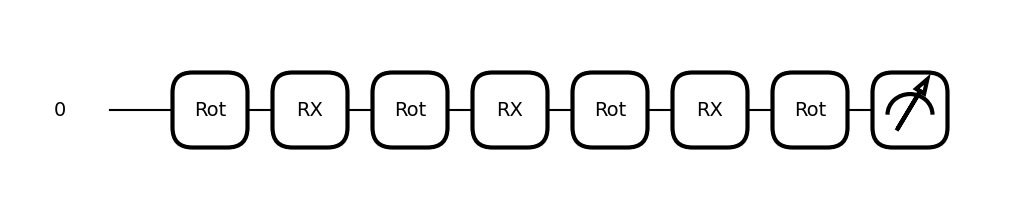

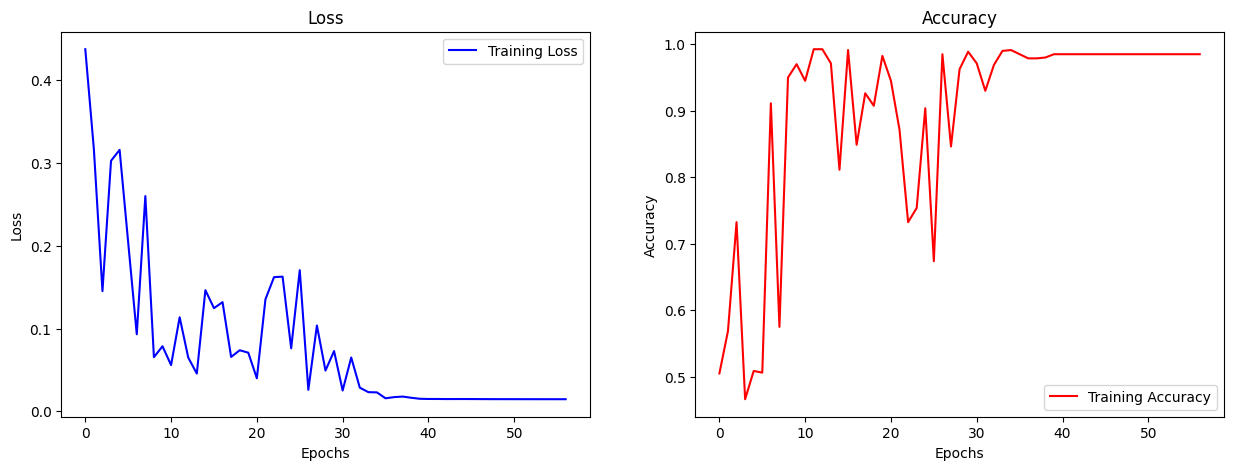

In [22]:
n_qubits = 1
n_layers = 3
lr = 0.2
ep = 100
acc = 0.995
auc = 0.995 

best_params_c3, history_c3 = load_classifier(n_layers, n_qubits, lr, ep, acc, auc)

circuit_3 = DataReuploadingClassifier(n_qubits, n_layers)
circuit_3.best_params = best_params_c3
circuit_3.history = history_c3

qml.draw_mpl(circuit_3.circuit)(X_train['F2'][0], circuit_3.best_params)
fig, ax = plot_history(circuit_3)

In [23]:
print('Accuracy on the training set: ', accuracy_score(y_train, circuit_3._predict(X_train['F2'])))
print('Accuracy on the test set: ', accuracy_score(y_test, circuit_3._predict(X_test['F2'])))

Accuracy on the training set:  0.9925
Accuracy on the test set:  0.995


En este caso específico, aumentar el número de capas no mejora la precisión del circuito. Sin embargo, es importante destacar que el circuito se estabiliza aproximadamente después de las 30 epochs, lo que indica que se estabiliza más rápidamente que el circuito 2. No obstante, es crucial tener en cuenta que para afirmar que el aumento en el número de capas facilitó el entrenamiento se necesitarían realizar más pruebas y análisis exhaustivos.

Training Data


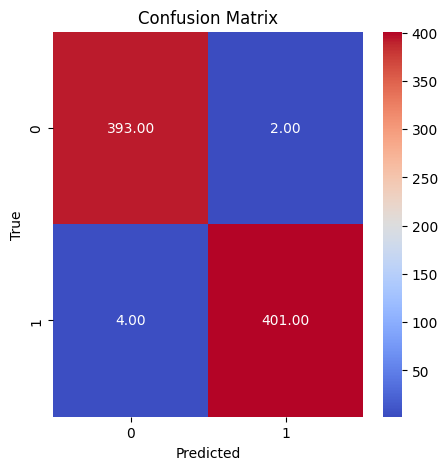

Test Data


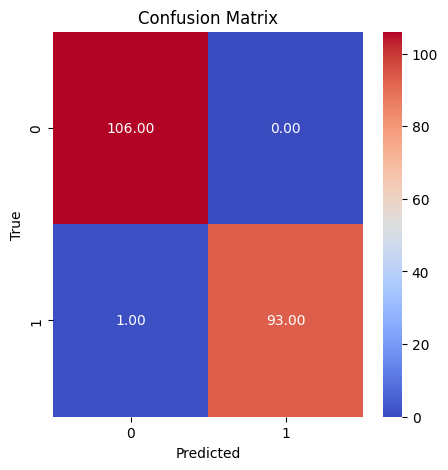

In [24]:
# Confusion matrix
print('Training Data')
fig, ax = plot_confusion_matrix(y_train, circuit_3._predict(X_train['F2']))
plt.show()

print('Test Data')
fig, ax = plot_confusion_matrix(y_test, circuit_3._predict(X_test['F2']))
plt.show()

Training Data


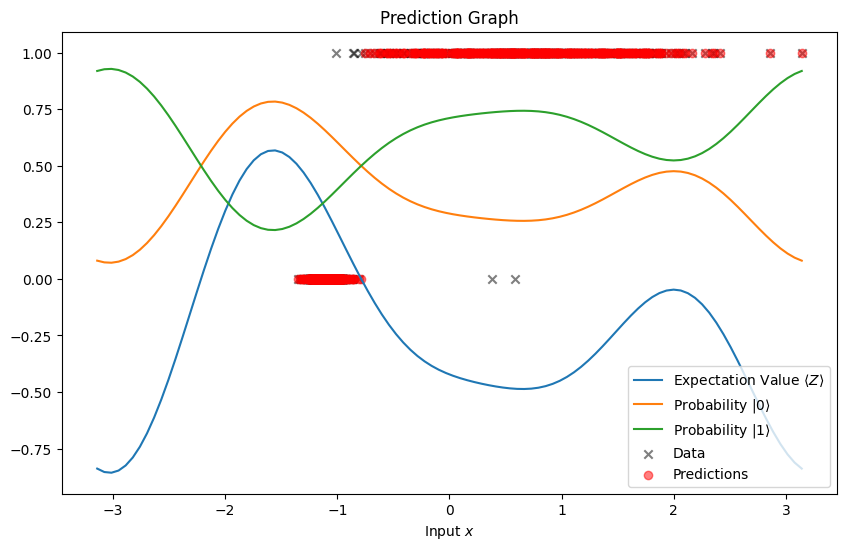

Test Data


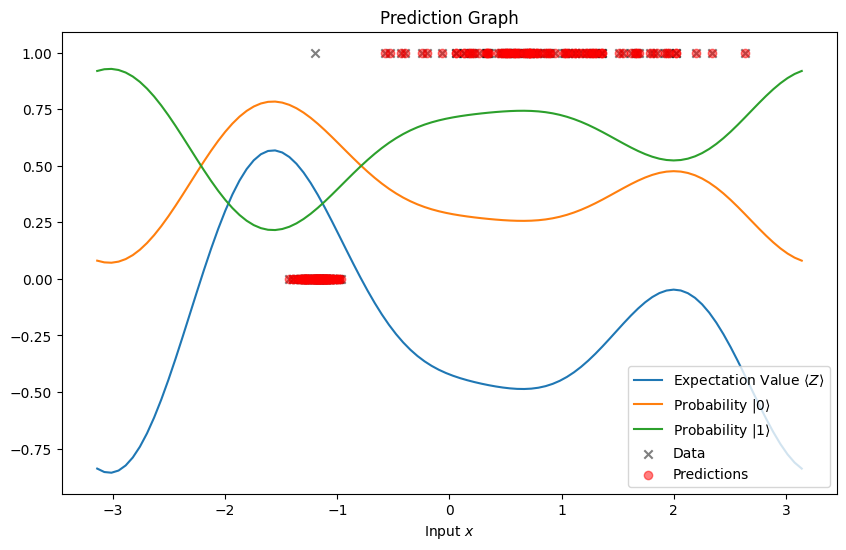

In [25]:
print('Training Data')
fig, ax = prediction_graph(circuit_3, X_train['F2'], y_train)
plt.show()

print('Test Data')
fig, ax = prediction_graph(circuit_3, X_test['F2'], y_test)
plt.show()

## Circuito 4

- Número de Qubits: 2
- Número de Layers: 1
- Número de Parámetros: 12 (3 por cada rotación)

**Accuracies:**

- Training Accuracy: 0.99
- Test Accuracy: 0.99

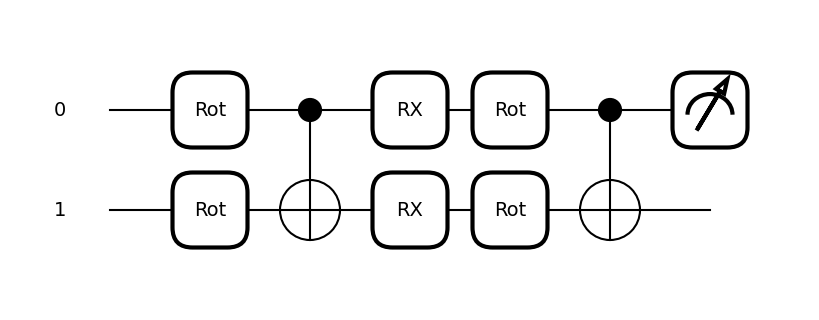

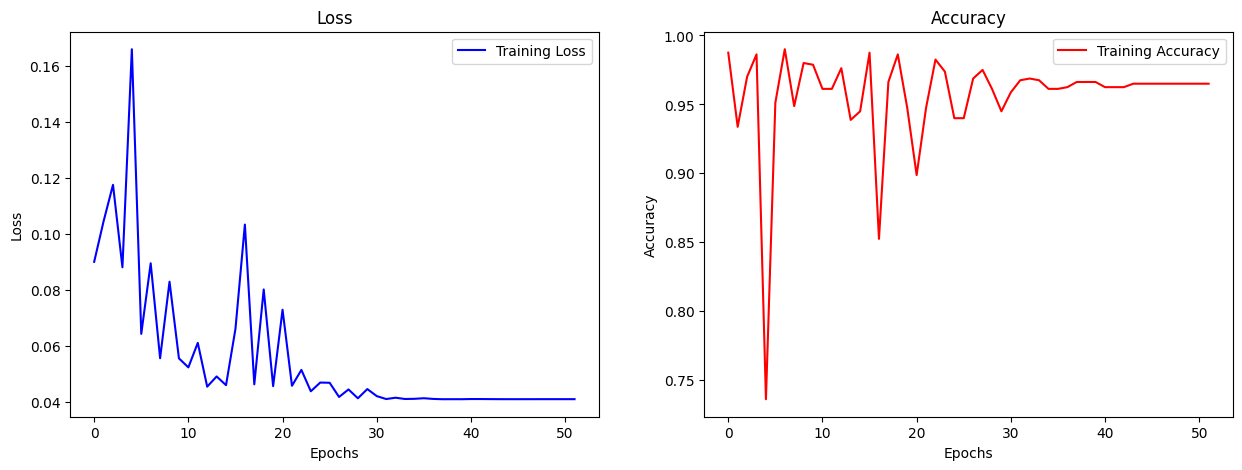

In [26]:
n_qubits = 2
n_layers = 1
lr = 0.2
ep = 100
acc = 0.990
auc = 0.989 

best_params_c4, history_c4 = load_classifier(n_layers, n_qubits, lr, ep, acc, auc)

circuit_4 = DataReuploadingClassifier(n_qubits, n_layers)
circuit_4.best_params = best_params_c4
circuit_4.history = history_c4

qml.draw_mpl(circuit_4.circuit)(X_train['F2'][0], circuit_4.best_params)
fig, ax = plot_history(circuit_4)

En este caso particular, al utilizar 2 qubits, es factible implementar una capa de entrelazamiento entre estos qubits. No obstante, es importante destacar que el uso de una única capa de codificación no permite al circuito aproximar una función que posea más de una frecuencia.

In [27]:
print('Accuracy on the training set: ', accuracy_score(y_train, circuit_4._predict(X_train['F2'])))
print('Accuracy on the test set: ', accuracy_score(y_test, circuit_4._predict(X_test['F2'])))

Accuracy on the training set:  0.99
Accuracy on the test set:  0.99


En este caso concreto, se logró una precisión (accuracy) de 0.99 tanto en el conjunto de entrenamiento como en el de prueba. Por consiguiente, no se observó una mejora en la precisión del circuito al emplear más de un qubit y entrelazamiento.

Training Data


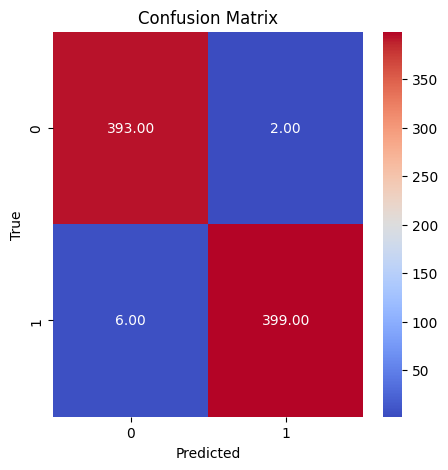

Test Data


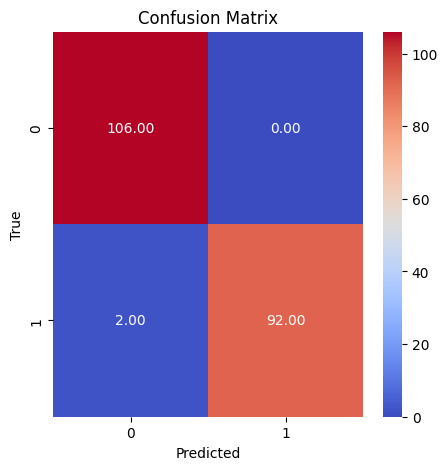

In [28]:
# Confusion matrix
print('Training Data')
fig, ax = plot_confusion_matrix(y_train, circuit_4._predict(X_train['F2']))
plt.show()

print('Test Data')
fig, ax = plot_confusion_matrix(y_test, circuit_4._predict(X_test['F2']))
plt.show()

Training Data


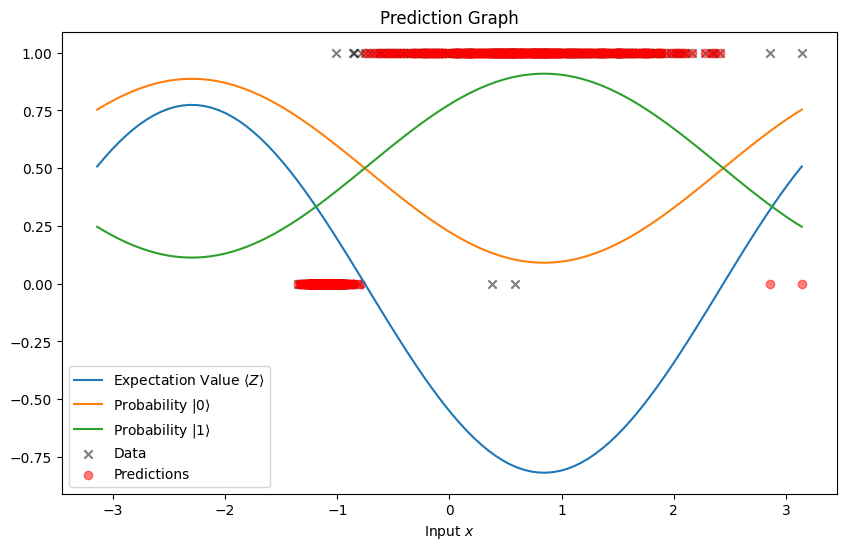

Test Data


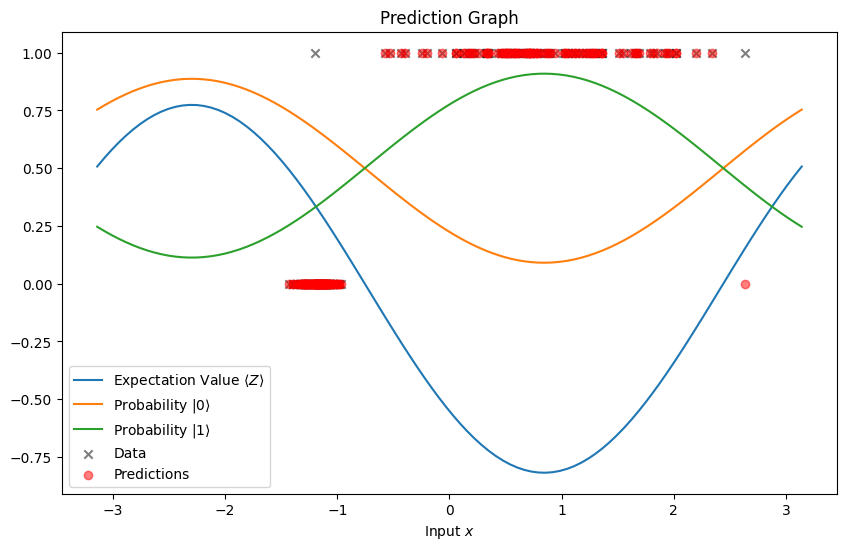

In [29]:
print('Training Data')
fig, ax = prediction_graph(circuit_4, X_train['F2'], y_train)
plt.show()

print('Test Data')
fig, ax = prediction_graph(circuit_4, X_test['F2'], y_test)
plt.show()

Es evidente que no se observaron mejoras al emplear más recursos, y la única diferencia en los resultados respecto al caso de un qubit se debió a una fase en la función que se aproxima.

## Circuito 5

- Número de Qubits: 2
- Número de Layers: 2
- Número de Parámetros: 18 (3 por cada rotación)

**Accuracies:**

- Training Accuracy: 0.9925
- Test Accuracy: 0.995

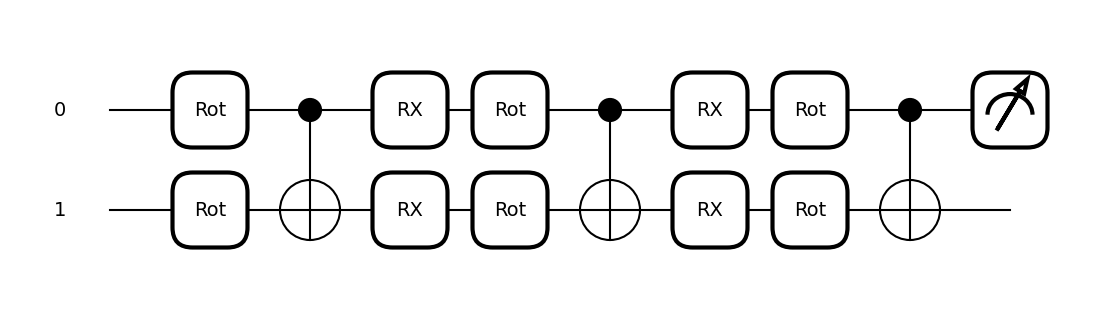

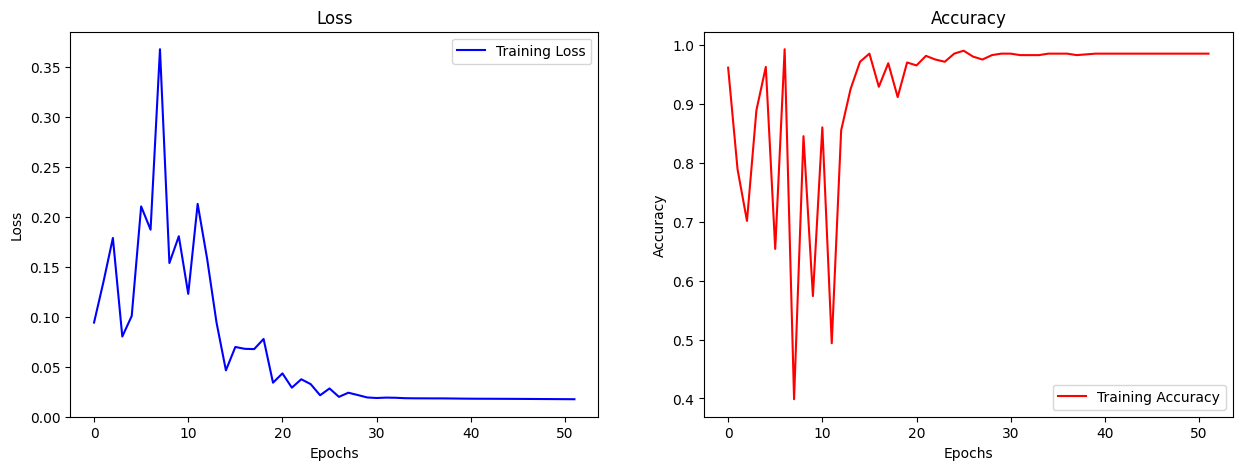

In [30]:
n_qubits = 2
n_layers = 2
lr = 0.2
ep = 100
acc = 0.995
auc = 0.995

best_params_c5, history_c5 = load_classifier(n_layers, n_qubits, lr, ep, acc, auc)

circuit_5 = DataReuploadingClassifier(n_qubits, n_layers)
circuit_5.best_params = best_params_c5
circuit_5.history = history_c5

qml.draw_mpl(circuit_5.circuit)(X_train['F2'][0], circuit_5.best_params)
fig, ax = plot_history(circuit_5)

En este caso específico, se destaca que el entrenamiento se estabiliza aproximadamente después de las 20 epochs. Esto sugiere que se requiere un menor número de epochs para que el circuito alcance la convergencia en comparación con los circuitos anteriores. Sin embargo, es importante resaltar que se necesitarían más pruebas para afirmar con certeza que el circuito se estabiliza más rápidamente.

In [31]:
print('Accuracy on the training set: ', accuracy_score(y_train, circuit_5._predict(X_train['F2'])))
print('Accuracy on the test set: ', accuracy_score(y_test, circuit_5._predict(X_test['F2'])))

Accuracy on the training set:  0.9925
Accuracy on the test set:  0.995


Los datos de precisión (accuracy) representan los valores máximos obtenidos por los circuitos anteriores. Esto sugiere que el aumento en la cantidad de capas y qubits no mejora la precisión del circuito para este problema en particular.

Training Data


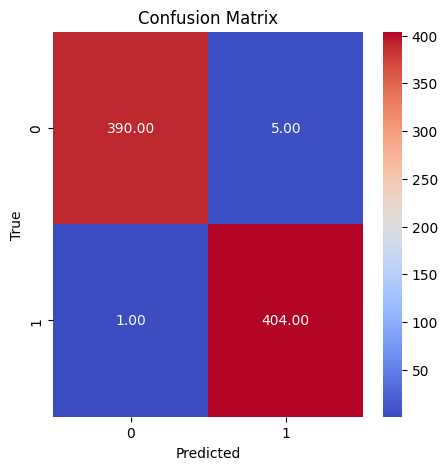

Test Data


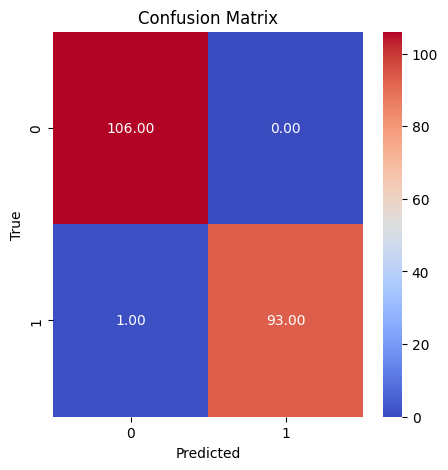

In [32]:
# Confusion matrix
print('Training Data')
fig, ax = plot_confusion_matrix(y_train, circuit_5._predict(X_train['F2']))
plt.show()

print('Test Data')
fig, ax = plot_confusion_matrix(y_test, circuit_5._predict(X_test['F2']))
plt.show()

Training Data


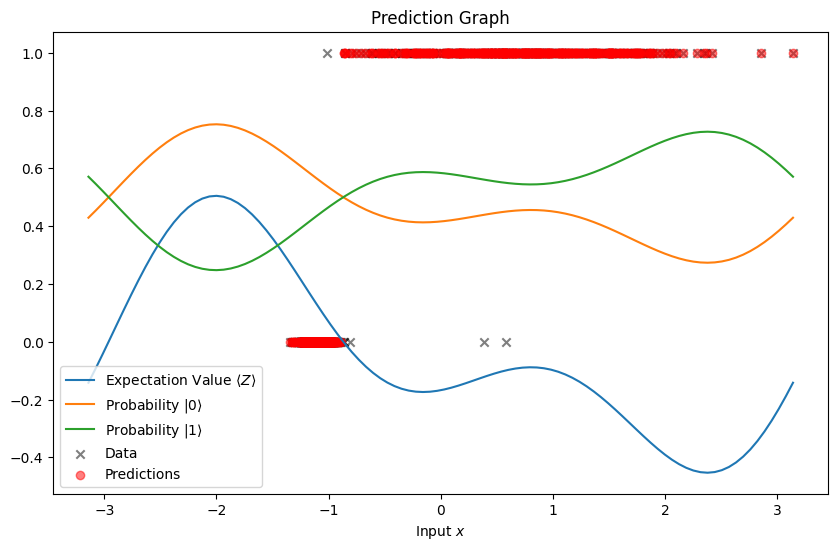

Test Data


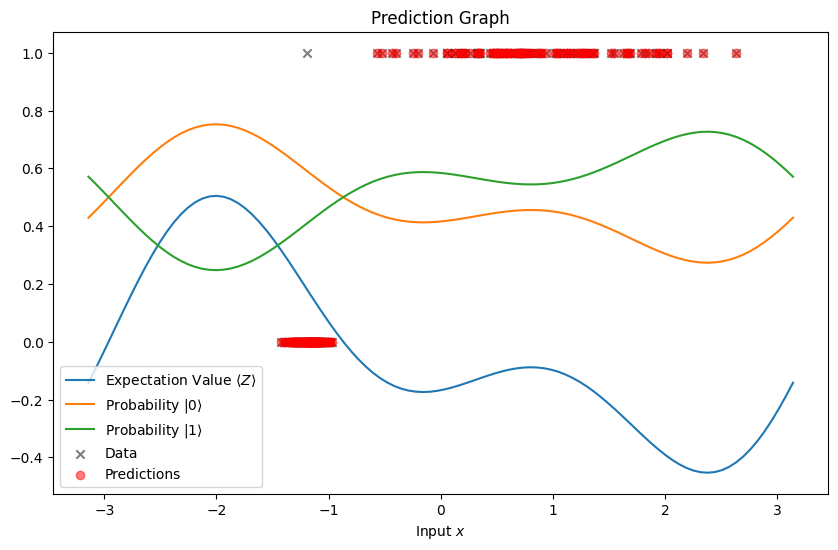

In [33]:
print('Training Data')
fig, ax = prediction_graph(circuit_5, X_train['F2'], y_train)
plt.show()

print('Test Data')
fig, ax = prediction_graph(circuit_5, X_test['F2'], y_test)
plt.show()

# Conclusiones

En resumen, tras analizar varios enfoques utilizando diferentes configuraciones de capas y qubits, se observó que:

- Aumentar la cantidad de qubits y adicionar entrelazamiento no necesariamente mejora la precisión del circuito para este problema específico.
- La precisión máxima lograda previamente no se superó al incrementar las capas y qubits, indicando que la complejidad adicional no se traduce en una mejora significativa en la precisión. Esto se debe a la simplicidad del problema.
- Es importante tener en cuenta que la complejidad del modelo no siempre garantiza mejoras en el rendimiento y que cada problema puede requerir un enfoque particular.

Con este problema, además se pudo poner en práctica los resultados obtenidos en las investigaciones de las referencias mencionadas [^1] [^2], demostrando que un qubit sirve como clasificador y que el número de frecuencias alcanzables por el circuito variacional depende de la cantidad de capas de Data Reuploading.

Por lo tanto, es fundamental evaluar de manera meticulosa y considerar la complejidad del modelo en relación con la mejora real en la capacidad predictiva al abordar problemas específicos de clasificación con circuitos cuánticos.

[^1]: https://arxiv.org/abs/1907.02085
[^2]: https://arxiv.org/abs/2008.08605